# Getting Started With Hyperparameter Optimization Using Amazon SageMaker Automatic Model Tuning

## Background - What are we doing?

Machine Learning (ML) models are getting better and better. Subsequently they are taking the world by storm. Their performance relies on the right training data and choosing the right model/algorithm. But it does not end here. Typically, algorithms defer some design decisions to the ML practitioner to adopt for their specific data and task. These deferred design decisions manifest themselves as so called *hyperparameters*.

What does that name mean? The result of a machine learning training, the model, can be largely seen as a collection of parameters that were learned during training. Hence the parameters that are used to configure the machine learning training are then called hyperparameters, i.e. parameters describing the creation of parameters. At any rate, they are of very practical use, such as the number of epochs to train, the learning rate, the max depth of a decision tree and so forth. And they have a major impact on the ultimate performance of your model.

Selecting the right parameters and their value ranges starts with the practitioner's theoretical knowledge of the model to train. This defines the boundaries of the search space, but then it is also necessary to explore this search space empirically to find a good combination of parameters that will result in a high performing model.

Luckily, we do not have to manually search that space, because SageMaker Automatic Model Tuning (AMT) is here to help. We point AMT in the right direction by defining the overall search space and AMT then takes over and coordinates the exploration of that space and fully automatically runs training jobs to efficiently evaluate the space. This then results in a good combination of hyper parameter values to train a high performing model.

*In an upcoming article we will extend the notion of __just__ finding the best parameters to then __also__ include learning about the search space and to what parameter ranges a model is sensitive, as well as turning a one-shot tuning activity into a multi-step conversation with the ML practitioner, to learn together. Exciting!*

In this tutorial we will walk through Amazon SageMaker Automatic Model Tuning (AMT), using a built-in XGBoost algorithm provided by Amazon SageMaker. Additional information can be found in the documentation pages below:
* For more information on running a simple hyperparameter tuning job: https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning-ex.html
* For documentation on using the HyperParameterTuner API with the SageMaker Python SDK: https://sagemaker.readthedocs.io/en/stable/api/training/tuner.html

## Overview

This notebook is split into the following sections:
* Setup and Imports
* Load and Prepare dataset
* Train a SageMaker Built-In XGBoost Algorithm
* Train and Tune a SageMaker Built-In XGBoost Algorithm
* View the AMT job statistics 
* Visualize AMT job results and tuned Hyperparameters


### Setup and Imports

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

We ran this notebook using Amazon SageMaker with the version you see in the output of the next cell below. If your version is lower and you encounter issues, we recommend uncommenting the code below to upgrade your pip and SageMaker versions. Make sure to restart your kernel after upgrading for the changes to take effect.

In [2]:
import sagemaker

sagemaker.__version__ 

sagemaker.config INFO - Not applying SDK defaults from location: /Library/Application Support/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/mkamp/Library/Application Support/sagemaker/config.yaml


'2.221.1'

In [3]:
#!pip install --upgrade --quiet pip "sagemaker==2.121.0" # upgrade SageMaker to the recommended version

In [4]:
import io
import os
import argparse
import traceback
import boto3
import numpy as np
import pandas as pd

from pathlib import Path

In [5]:
# SDK setup
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
sm = boto3.client('sagemaker')
boto_sess = boto3.Session(region_name=region)
sm_sess = sagemaker.session.Session(boto_session=boto_sess, sagemaker_client=sm)

In [6]:
# Data layout and locations. 
# To store our data we are using a prefix in the Amazon SageMaker default bucket. Feel free to adjust to your preferences.

BUCKET = sm_sess.default_bucket()
PREFIX = 'amt-visualize-demo'

# Eventual output destination for our XGBoost model
output_path = f's3://{BUCKET}/{PREFIX}/output'
output_path

's3://sagemaker-eu-west-1-811243659808/amt-visualize-demo/output'

## Load and Prepare dataset 

In [7]:
!mkdir -p data

The focus of this notebook is on Hyperparameter Optimization. Hence the actual task and data only play a supporting role. But to give some brief context, we are optimizing the hyperparameters of an XGBoost model that should classify handwritten digits. 

We use the [Optical Recognition of Handwritten Digits Data Set](https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits) via scikit-learn:

_Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science._

In [8]:
from sklearn import datasets

digits         = datasets.load_digits()
digits_df      = pd.DataFrame(digits.data)
digits_df['y'] = digits.target
digits_df.insert(0, 'y', digits_df.pop('y')) # XGBoost expects the target to be the first column 

digit: 4


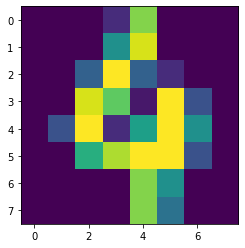

In [9]:
from matplotlib import pyplot as plt

print('digit:', int(digits_df.iloc[100].y))
plt.imshow(digits_df.iloc[100, 1:].values.reshape(8, -1));

In [10]:
# randomly sort the data then split out into train 70% and validation 30% sets
train_data, valid_data= np.split(
    digits_df, [int(0.7 * len(digits_df))]
)

In [11]:
train_data.to_csv('data/train.csv', index=False, header=False)
valid_data.to_csv('data/valid.csv', index=False, header=False)

In [12]:
boto_sess.resource('s3').Bucket(BUCKET).Object(os.path.join(PREFIX, 'data/train/train.csv')).upload_file('data/train.csv')
boto_sess.resource('s3').Bucket(BUCKET).Object(os.path.join(PREFIX, 'data/valid/valid.csv')).upload_file('data/valid.csv')

We upload our train and validation datasets into [Amazon S3](https://aws.amazon.com/s3/). Amazon SageMaker will launch training jobs on our behalf and those will read the data directly from S3.

## Train an Amazon SageMaker Built-In XGBoost Algorithm

SageMaker provides many [built-in algorithms](https://docs.aws.amazon.com/sagemaker/latest/dg/algos.html). For our example we use the popular XGBoost algorithm. To select it for our training it is identified by an image URI as described in the docs here:
https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html

In below code you can see how we lookup the respective image and version of the algorithm. We then define the hyperparameters and instantiate an Estimator that describes our training. For a list of hyperparameters and their meaning for this algorithm check out the [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost_hyperparameters.html). 

Please recognize that for our small dataset we also specify the use of a small CPU based instance type for our training, specifically `ml.m5.large`.

Eventually we call `fit()` to start the training and to pass in references to where our training and validation data can be found. 

__Side note__: Strictly speaking it would not be necessary to call the `fit()` method here for an individual training run. We will let SageMaker Automatic Model Tuning (AMT) instantiate and control the individual training runs later. We just need to pass in the Estimator we defined here as a template. We could comment out the call to `fit()`.

However, calling `fit()` shows us how one training run works and helps us to get acquainted with the algorithm and the log outputs, which are also available in Amazon CloudWatch. This works even though the actual execution is happening on a different EC2 machine. SageMaker makes the log outputs directly available in this notebook here. Neat, right?

In [13]:
%%time
from sagemaker import image_uris
from sagemaker.session import Session
from sagemaker.inputs import TrainingInput


# lookup the XGBoost image URI and build an XGBoost container
xgboost_container = sagemaker.image_uris.retrieve('xgboost', region, '1.5-1')
print('Algorithm container image:', xgboost_container)

hyperparameters = {
        'num_class': 10,
        'max_depth': 5,
        'eta':0.2,
        'alpha': 0.2, 
        'objective':'multi:softmax',
        'eval_metric':'accuracy',
        'num_round':200,
        'early_stopping_rounds': 5}

# construct a SageMaker estimator that calls the XGBoost container
estimator = sagemaker.estimator.Estimator(
    image_uri=xgboost_container, 
    hyperparameters=hyperparameters,
    role=role,
    instance_count=1, 
    instance_type='ml.m5.large', 
    volume_size=5, # 5 GB 
    output_path=output_path
)

# define the data type and paths to the training and validation datasets
s3_input_train = TrainingInput(s3_data=f's3://{BUCKET}/{PREFIX}/data/train', content_type='csv')
s3_input_valid = TrainingInput(s3_data=f's3://{BUCKET}/{PREFIX}/data/valid', content_type='csv')

# execute the XGBoost training job
estimator.fit({'train': s3_input_train, 'validation': s3_input_valid}) # Optional. See comment above this cell.

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2024-05-30-18-32-15-276


Algorithm container image: 141502667606.dkr.ecr.eu-west-1.amazonaws.com/sagemaker-xgboost:1.5-1
2024-05-30 18:32:15 Starting - Starting the training job...
2024-05-30 18:32:29 Starting - Preparing the instances for training...
2024-05-30 18:32:59 Downloading - Downloading input data...
2024-05-30 18:33:44 Downloading - Downloading the training image......
2024-05-30 18:34:45 Training - Training image download completed. Training in progress.
2024-05-30 18:34:45 Uploading - Uploading generated training model./miniconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
[2024-05-30 18:34:40.164 ip-10-0-99-24.eu-west-1.compute.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2024-05-30 18:34:40.187 ip-10-0-99-24.eu-west-1.compute.internal:7 INFO profiler_config_parser.py:111] Us

## Train and Tune an Amazon SageMaker Built-In XGBoost Algorithm

Analogous to the Estimator above we now setup the HyperparameterTuner. We pass in the estimator object as a template for the trials to be run and a range of hyperparameters to define what search space to explore. Our documentation on [tuning XGBoost](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost-tuning.html) gives you some tips on choosing parameter ranges and which objective to use.

You also see that we specify the number of training jobs to be run in total, as well as how many should run in parallel. Further you can select among many [strategies](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_HyperParameterTuningJobConfig.html#sagemaker-Type-HyperParameterTuningJobConfig-Strategy). In this notebook we use `Bayesian` as strategy. It uses a systematic approach to evaluate the search space. And it incorporates knowledge gained from earlier training runs (trials) when picking better hyperparameters to evaluate in the later trials, during the same __tuning__ job run. 

*Bayesian Search as a strategy is an excellent default. In an upcoming notebook and article we will additionally contrast and compare different strategies.*

In [14]:
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner

n_jobs = 50
n_parallel_jobs = 3

hpt_ranges = {
    'alpha': ContinuousParameter(0.01, .5),
    'eta': ContinuousParameter(0.1, .5),
    'min_child_weight': ContinuousParameter(0., 2.),
    'max_depth': IntegerParameter(1, 10)
}

tuner_parameters = {
    'estimator': estimator,
    'base_tuning_job_name': 'bayesian',                   
    'objective_metric_name': 'validation:accuracy',
    'objective_type': 'Maximize',
    'hyperparameter_ranges': hpt_ranges,
    'strategy': 'Bayesian',
    'max_jobs': n_jobs,
    'max_parallel_jobs': n_parallel_jobs
}

Analogous to the actual training with the estimator above, we also kick things off by calling `fit()`. This time on the HyperparameterTuner.

In [15]:
tuner = HyperparameterTuner(**tuner_parameters)
tuner.fit({'train': s3_input_train, 'validation': s3_input_valid}, wait=False)
tuner_name = tuner.describe()['HyperParameterTuningJobName']
print(f'tuning job submitted: {tuner_name}.')

INFO:sagemaker:Creating hyperparameter tuning job with name: bayesian-240530-2035


tuning job submitted: bayesian-240530-2035.


Amazon SageMaker AMT, here the HyperparameterTuner, now orchestrates different training jobs (trials) over a period of time. 

We use `tuner.wait()` to pause this notebook's execution until the AMT job is completed and we can work with the results. Depending on the number of jobs and the level of parallelization this may take some time. For the example below it may take up to 30 minutes for 50 jobs. During this time you can view the status of your jobs in the console by navigating to Amazon SageMaker > Training > Hyperparameter tuning jobs.

For more information on AMT job monitoring, see: https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning-monitor.html

In [16]:
tuner.wait()

.................................................................................................................................................................................................................!


## View the AMT job statistics and results 

Your tuning jobs can be accessed from the Amazon SageMaker console at https://console.aws.amazon.com/sagemaker/. Select Hyperparameter tuning jobs from the Training menu to see the list. More information here: https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning-monitor.html

You can also check the results of the jobs programmatically and investigate the hyperparameters used, the final value achieved in the objective function and the total training time per job.

Furthermore you can evaluate the results programmatically, which we will look into now.

#### 1. Via the Amazon SageMaker Python SDK

The SDK conveniently provides access to the tuning results as a Pandas dataframe. 

In [17]:
sagemaker.HyperparameterTuningJobAnalytics(tuner_name).dataframe()[:10]

,alpha,eta,max_depth,min_child_weight,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,0.063792,0.448416,2.0,1.474946,bayesian-240530-2035-050-9ec64322,Completed,0.88148,2024-05-30 20:52:43+02:00,2024-05-30 20:53:22+02:00,39.0
1,0.251326,0.448000,2.0,1.144669,bayesian-240530-2035-049-37c9ab3b,Completed,0.88518,2024-05-30 20:52:34+02:00,2024-05-30 20:53:13+02:00,39.0
2,0.210467,0.462129,2.0,0.190347,bayesian-240530-2035-048-eee2d00f,Completed,0.87963,2024-05-30 20:52:32+02:00,2024-05-30 20:53:11+02:00,39.0
3,0.074670,0.450334,2.0,1.834558,bayesian-240530-2035-047-ed99c9ea,Completed,0.87963,2024-05-30 20:51:46+02:00,2024-05-30 20:52:25+02:00,39.0
4,0.346645,0.433639,2.0,1.955345,bayesian-240530-2035-046-96c83294,Completed,0.87222,2024-05-30 20:51:37+02:00,2024-05-30 20:52:16+02:00,39.0
5,0.299174,0.443982,2.0,0.967672,bayesian-240530-2035-045-161749a6,Completed,0.89074,2024-05-30 20:51:36+02:00,2024-05-30 20:52:19+02:00,43.0
6,0.067596,0.456789,2.0,1.971977,bayesian-240530-2035-044-e902c7a2,Completed,0.88889,2024-05-30 20:50:50+02:00,2024-05-30 20:51:31+02:00,41.0
7,0.028849,0.463609,2.0,1.795434,bayesian-240530-2035-043-98fbc12c,Completed,0.88148,2024-05-30 20:50:40+02:00,2024-05-30 20:51:19+02:00,39.0
8,0.247213,0.473596,2.0,1.342878,bayesian-240530-2035-042-3f1ed3a0,Completed,0.87037,2024-05-30 20:50:38+02:00,2024-05-30 20:51:17+02:00,39.0
9,0.388552,0.455118,2.0,1.544002,bayesian-240530-2035-041-73244224,Completed,0.88889,2024-05-30 20:49:54+02:00,2024-05-30 20:50:37+02:00,43.0


#### 2. Via the AWS SDK for Python (Boto3)

With the boto3 client we can review the results of a HPO job using [`describe_hyper_parameter_tuning_job()`](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_DescribeHyperParameterTuningJob.html) function.

It returns a Python dictionary with comprehensive information. Below you see the output scoped to the `BestTrainingJob`.

In [18]:
#sm.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuner_name)   # to review all data
sm.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuner_name)['BestTrainingJob']

{'TrainingJobName': 'bayesian-240530-2035-045-161749a6',
 'TrainingJobArn': 'arn:aws:sagemaker:eu-west-1:811243659808:training-job/bayesian-240530-2035-045-161749a6',
 'CreationTime': datetime.datetime(2024, 5, 30, 20, 51, 33, tzinfo=tzlocal()),
 'TrainingStartTime': datetime.datetime(2024, 5, 30, 20, 51, 36, tzinfo=tzlocal()),
 'TrainingEndTime': datetime.datetime(2024, 5, 30, 20, 52, 19, tzinfo=tzlocal()),
 'TrainingJobStatus': 'Completed',
 'TunedHyperParameters': {'alpha': '0.29917442870770167',
  'eta': '0.44398234513742507',
  'max_depth': '2',
  'min_child_weight': '0.9676717280419793'},
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'validation:accuracy',
  'Value': 0.8907399773597717},
 'ObjectiveStatus': 'Succeeded'}

We can also utilize Boto3's [`list_training_jobs_for_hyper_parameter_tuning_job()`](https://docs.aws.amazon.com/cli/latest/reference/sagemaker/list-training-jobs-for-hyper-parameter-tuning-job.html) function to review the results. This can be sorted by the value of the objective function or by the metric definitions. More functions available for Amazon SageMaker with Boto3 are described on this page: https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/sagemaker.html

In [19]:
hpo_jobs = sm.list_training_jobs_for_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner_name,
    MaxResults=100,
    SortBy='FinalObjectiveMetricValue',
    SortOrder='Descending')

for job in hpo_jobs['TrainingJobSummaries'][:10]:
    job_descr = sm.describe_training_job(TrainingJobName=job['TrainingJobName'])
    metrics = {m['MetricName']:  m['Value'] for m in job_descr['FinalMetricDataList']}
    print(f'{job["TrainingJobName"]} Metrics: {metrics}')

bayesian-240530-2035-045-161749a6 Metrics: {'train:mlogloss': 0.014279999770224094, 'train:accuracy': 1.0, 'validation:accuracy': 0.8907399773597717, 'validation:mlogloss': 0.3374199867248535, 'ObjectiveMetric': 0.8907399773597717}
bayesian-240530-2035-044-e902c7a2 Metrics: {'train:mlogloss': 0.019999999552965164, 'train:accuracy': 1.0, 'validation:accuracy': 0.8888900279998779, 'validation:mlogloss': 0.3624100089073181, 'ObjectiveMetric': 0.8888900279998779}
bayesian-240530-2035-041-73244224 Metrics: {'train:mlogloss': 0.018479999154806137, 'train:accuracy': 1.0, 'validation:accuracy': 0.8888900279998779, 'validation:mlogloss': 0.35743001103401184, 'ObjectiveMetric': 0.8888900279998779}
bayesian-240530-2035-014-e36d3277 Metrics: {'train:mlogloss': 0.020029999315738678, 'train:accuracy': 1.0, 'validation:accuracy': 0.8870400190353394, 'validation:mlogloss': 0.3484500050544739, 'ObjectiveMetric': 0.8870400190353394}
bayesian-240530-2035-037-539e0d4a Metrics: {'train:mlogloss': 0.0238700

## Visualize AMT job results and tuned Hyperparameters

Finally, we want to interactively visualize the impact of our hyperparameters and their values on the optimization objective.

To do this, we utilize the Altair statistical visualization library for Python, and have written two custom analysis scripts `job_analytics.py` and `reporting_util.py` that we make available with this notebook.

In an upcoming notebook and article we will dive deeper into the analysis of this data. 

In [20]:
!pip install -Uq pip altair

Please ensure that the role used by SageMaker allows the `cloudwatch:ListMetrics` action on [IAM](https://console.aws.amazon.com/iam).

Setting altair renderer to png.
Tuning job bayesian-240530-2035      status: Completed

Number of training jobs with valid objective: 50
Lowest: 0.8611099720001221 Highest 0.8907399773597717


,alpha,eta,max_depth,min_child_weight,TrainingJobName,TrainingJobStatus,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds,TuningJobName,validation:accuracy
5,0.299174,0.443982,2.0,0.967672,bayesian-240530-2035-045-161749a6,Completed,2024-05-30 20:51:36+02:00,2024-05-30 20:52:19+02:00,43.0,bayesian-240530-2035,0.89074
6,0.067596,0.456789,2.0,1.971977,bayesian-240530-2035-044-e902c7a2,Completed,2024-05-30 20:50:50+02:00,2024-05-30 20:51:31+02:00,41.0,bayesian-240530-2035,0.88889
9,0.388552,0.455118,2.0,1.544002,bayesian-240530-2035-041-73244224,Completed,2024-05-30 20:49:54+02:00,2024-05-30 20:50:37+02:00,43.0,bayesian-240530-2035,0.88889
41,0.149170,0.447876,2.0,0.792075,bayesian-240530-2035-009-d0cfac9a,Completed,2024-05-30 20:39:44+02:00,2024-05-30 20:40:24+02:00,40.0,bayesian-240530-2035,0.88704
36,0.308642,0.463677,2.0,1.755610,bayesian-240530-2035-014-e36d3277,Completed,2024-05-30 20:41:22+02:00,2024-05-30 20:42:00+02:00,38.0,bayesian-240530-2035,0.88704
13,0.335140,0.446999,2.0,1.588256,bayesian-240530-2035-037-539e0d4a,Completed,2024-05-30 20:48:42+02:00,2024-05-30 20:49:26+02:00,44.0,bayesian-240530-2035,0.88704
33,0.257894,0.480777,2.0,0.887547,bayesian-240530-2035-017-0405b6f4,Completed,2024-05-30 20:42:16+02:00,2024-05-30 20:42:55+02:00,39.0,bayesian-240530-2035,0.88518
31,0.151844,0.466770,2.0,0.713452,bayesian-240530-2035-019-4a109339,Completed,2024-05-30 20:42:57+02:00,2024-05-30 20:43:36+02:00,39.0,bayesian-240530-2035,0.88518
21,0.239767,0.460919,2.0,0.857952,bayesian-240530-2035-029-22e5dab8,Completed,2024-05-30 20:45:46+02:00,2024-05-30 20:46:31+02:00,45.0,bayesian-240530-2035,0.88518
1,0.251326,0.448000,2.0,1.144669,bayesian-240530-2035-049-37c9ab3b,Completed,2024-05-30 20:52:34+02:00,2024-05-30 20:53:13+02:00,39.0,bayesian-240530-2035,0.88518


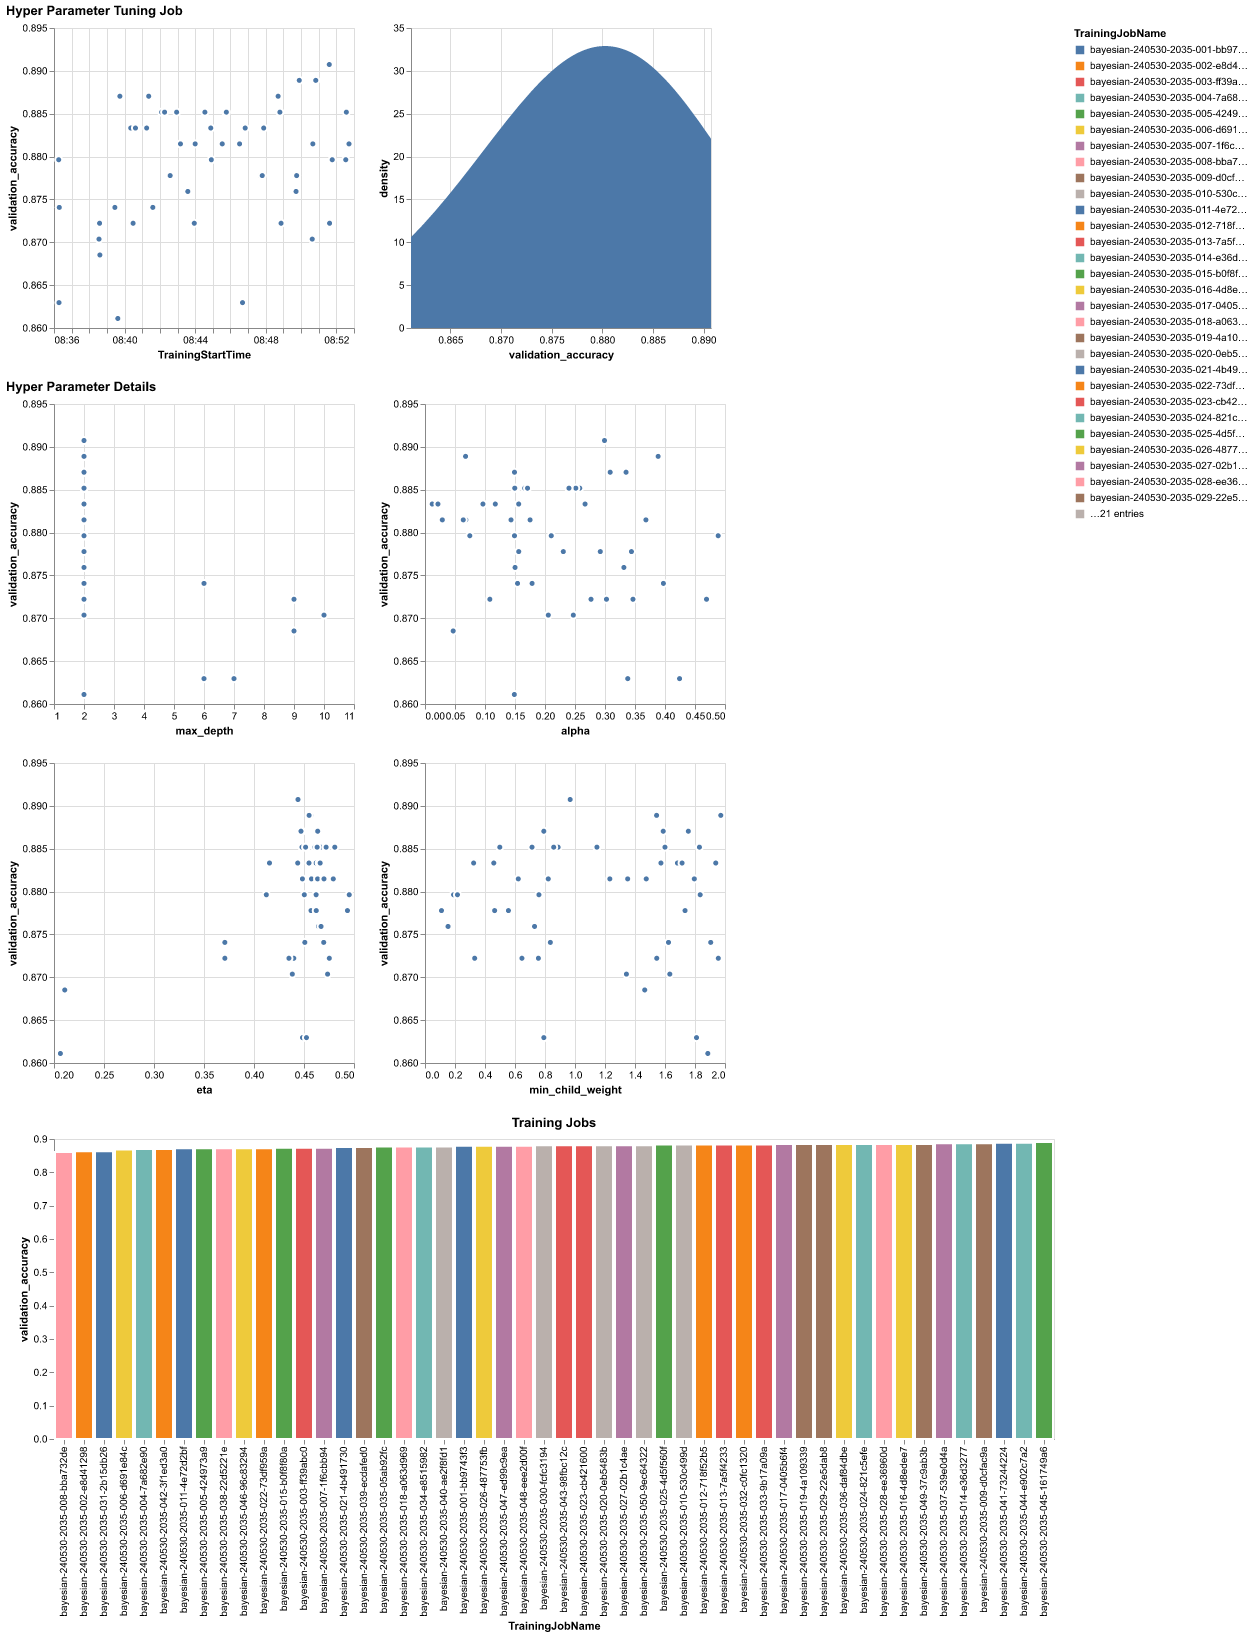

In [21]:
from amtviz import visualize_tuning_job
visualize_tuning_job(tuner, trials_only=True) 

## Cleanup 

To avoid incurring unwanted costs when you’re done experimenting with HPO, you must remove all files in your S3 bucket with the prefix `amt-visualize-demo` and also [shut down Studio resources](https://docs.aws.amazon.com/sagemaker/latest/dg/notebooks-run-and-manage-shut-down.html).

Uncomment and run the following code to remove all S3 files created by this notebook. Note that`{BUCKET}` is the variable with our bucket name that we defined earlier, you may also write your bucket name as plaintext here.

If you wish to keep the datasets or the model artifacts, you may modify the prefix in the code to `amt-visualize-demo/data` to only delete the data or `amt-visualize-demo/output` to only delete the model artifacts.

In [22]:
#!aws s3 rm s3://{BUCKET}/amt-visualize-demo --recursive